# Regressão linear

Este notebook foi demonstrado na palestra *Machine Learning com PostgreSQL - O Elefante vidente*, apresentada no *DBA Brasil 3.0*.

<img src=linear-regression01.gif />

In [3]:
%reload_ext sql
#%config SqlMagic.feedback=False
#%config SqlMagic.autopandas=True

In [4]:
%sql postgresql://guedes@:5434/guedes

'Connected: guedes@guedes'

In [5]:
%%sql 
select madlib.version();

 * postgresql://guedes@:5434/guedes
1 rows affected.


version
"MADlib version: 1.14, git revision: unknown, cmake configuration time: sáb mai 5 00:37:44 UTC 2018, build type: RelWithDebInfo, build system: Linux-3.16.0-4-amd64, C compiler: gcc 4.9.2, C++ compiler: g++ 4.9.2"


# I. Carregar os dados

## Método clássico

Cria-se a estrutura de tabelas que vão receber os dados, isto se já não existirem, o que facilita.

In [6]:
%%sql 
DROP TABLE IF EXISTS casas;

CREATE TABLE casas (
    id INT,
    taxas INT,
    quartos INT,
    banheiros FLOAT,
    preco INT,
    tamanho INT,
    lote INT
);

 * postgresql://guedes@:5434/guedes
Done.
Done.


[]

Carregamos então os dados nas tabelas, neste exemplo no formato de `INSERT`, mas poderia ser via `COPY` que é um método que o Postgres tem de carregar uma grande quantidade de dados de modo bem performatico.

In [8]:
%%sql
INSERT INTO casas VALUES   
  (1 ,  590 ,       2 ,    1 ,  50000 ,  770 , 22100),
  (2 , 1050 ,       3 ,    2 ,  85000 , 1410 , 12000),
  (3 ,   20 ,       3 ,    1 ,  22500 , 1060 ,  3500),
  (4 ,  870 ,       2 ,    2 ,  90000 , 1300 , 17500),
  (5 , 1320 ,       3 ,    2 , 133000 , 1500 , 30000),
  (6 , 1350 ,       2 ,    1 ,  90500 ,  820 , 25700),
  (7 , 2790 ,       3 ,  2.5 , 260000 , 2130 , 25000),
  (8 ,  680 ,       2 ,    1 , 142500 , 1170 , 22000),
  (9 , 1840 ,       3 ,    2 , 160000 , 1500 , 19000),
 (10 , 3680 ,       4 ,    2 , 240000 , 2790 , 20000),
 (11 , 1660 ,       3 ,    1 ,  87000 , 1030 , 17500),
 (12 , 1620 ,       3 ,    2 , 118600 , 1250 , 20000),
 (13 , 3100 ,       3 ,    2 , 140000 , 1760 , 38000),
 (14 , 2070 ,       2 ,    3 , 148000 , 1550 , 14000),
 (15 ,  650 ,       3 ,  1.5 ,  65000 , 1450 , 12000);

 * postgresql://guedes@:5434/guedes
15 rows affected.


[]

E verificamos se a carga ocorreu com sucesso, conforme:

In [10]:
%sql SELECT * FROM casas ORDER BY id;

 * postgresql://guedes@:5434/guedes
15 rows affected.


id,taxas,quartos,banheiros,preco,tamanho,lote
1,590,2,1.0,50000,770,22100
2,1050,3,2.0,85000,1410,12000
3,20,3,1.0,22500,1060,3500
4,870,2,2.0,90000,1300,17500
5,1320,3,2.0,133000,1500,30000
6,1350,2,1.0,90500,820,25700
7,2790,3,2.5,260000,2130,25000
8,680,2,1.0,142500,1170,22000
9,1840,3,2.0,160000,1500,19000
10,3680,4,2.0,240000,2790,20000


## Com dados federados

No Postgres é possivel criar uma tabela "virtual" que é uma intermediaria para você consultar fontes de dados externas, por exemplo você não precisaria carregar os dados, voce poderia ler de um arquivo numa pasta compartilhada, por exemplo. Voce poderia ler dados de um outro banco Postgres, ou ainda outros bancos como MySQL, SQLServer, por exemplo.

Abaixo tem um exemplo de como criar uma tabela deste tipo, conhecida como `FOREIGN TABLE`, onde supõem-se que exista uma pasta compartilhada onde arquivos `CSV` de pacientes são gerados por uma aplicação, então é possivel criar uma `FOREIGN TABLE` dentro do banco que aponta para esta tabela, conforme o exemplo abaixo:

In [ ]:
%%sql postgresql://postgres@:5434/guedes

CREATE EXTENSION IF NOT EXISTS file_fdw;

CREATE SERVER IF NOT EXISTS file_server FOREIGN DATA WRAPPER file_fdw;

GRANT USAGE ON FOREIGN SERVER file_server TO guedes;
GRANT USAGE ON FOREIGN DATA WRAPPER file_fdw TO guedes;


In [ ]:
%sql postgresql://guedes@:5434/guedes

In [ ]:
CREATE FOREIGN TABLE IF NOT EXISTS pacientes 
(
  id INTEGER NOT NULL,
  segundo_ataque INTEGER,
  tratamento INTEGER,
  traco_anciedade INTEGER
) SERVER file_server
OPTIONS ( filename '/shared/pacientes.csv', format 'csv' );

A tabela acima é criada uma única vez, mas o arquivo `pacientes.csv` pode ser alterado sempre, e a cada `SELECT` feito na tabela os dados retornados são do arquivo.

# II. Treinar o modelo de regressão

Geramos inicialmente uma simples regressão para todos os dados.

In [15]:
%%sql
DROP TABLE IF EXISTS casas_linregr, casass_linregr_summary;

SELECT madlib.linregr_train( 'casas',
                             'casas_linregr',
                             'preco',
                             'ARRAY[1, taxas, quartos, tamanho]'
                           );

 * postgresql://guedes@:5434/guedes
Done.
1 rows affected.


linregr_train
""


E só por curiosidade, podemos ver o que o modelo gerou internamente, um simples `SELECT` permite isto.

In [16]:
%sql SELECT * FROM casas_linregr_summary;

 * postgresql://guedes@:5434/guedes
1 rows affected.


method,source_table,out_table,dependent_varname,independent_varname,num_rows_processed,num_missing_rows_skipped,grouping_col
linregr,casas,casas_linregr,preco,"ARRAY[1, taxas, quartos, tamanho]",15,0,None


# III. Treinar o modelo agrupando

Agora geramos três modelos, um para cada valor de "bedroom".

In [19]:
%%sql 
DROP TABLE IF EXISTS casas_linregr_bedroom, casas_linregr_bedroom_summary;

SELECT madlib.linregr_train( 'casas',
                             'casas_linregr_quartos',
                             'preco',
                             'ARRAY[1, taxas, banheiros, tamanho]',
                             'quartos'
                           );

 * postgresql://guedes@:5434/guedes
Done.
1 rows affected.


linregr_train
""


E só por curiosidade, podemos ver o que o modelo gerou internamente, um simples `SELECT` permite isto.

In [21]:
%sql SELECT * FROM casas_linregr_quartos_summary;

 * postgresql://guedes@:5434/guedes
1 rows affected.


method,source_table,out_table,dependent_varname,independent_varname,num_rows_processed,num_missing_rows_skipped,grouping_col
linregr,casas,casas_linregr_quartos,preco,"ARRAY[1, taxas, banheiros, tamanho]",15,0,quartos


# Revisando o modelo

In [22]:
%%sql
SELECT * FROM casas_linregr;

 * postgresql://guedes@:5434/guedes
1 rows affected.


coef,r2,std_err,t_stats,p_values,condition_no,num_rows_processed,num_missing_rows_skipped,variance_covariance
"[46312.6200010278, 28.0425364522844, -33109.6856122436, 85.7048457939907]",0.811542286900626,"[40885.2454316108, 14.2433210730307, 19630.7062616626, 33.1022531471885]","[1.13274653269467, 1.96882007422988, -1.6866273261347, 2.58909402368793]","[0.28140758903869, 0.0746820465710941, 0.119794838361139, 0.0251788501326571]",12500.8979304987,15,0,"[[1671603294.00305, 109751.042885517, -599718662.85672, -94576.2352907573], [109751.042885517, 202.872195189441, 25239.3991399221, -344.624217495655], [-599718662.85672, 25239.3991399221, 385364628.331677, -343973.728465182], [-94576.2352907572, -344.624217495655, -343973.728465182, 1095.75916342055]]"


Como os valores de algumas colunas estão como `array`, no Postgres temos o `unnest`, que permite ver os resultados um pouco melhor.

In [23]:
%%sql
SELECT unnest(ARRAY['intercept','taxas','banheiros','tamanho']) as attribute,
       unnest(coef) as coefficient,
       unnest(std_err) as standard_error,
       unnest(t_stats) as t_stat,
       unnest(p_values) as pvalue
FROM houses_linregr;

 * postgresql://guedes@:5434/guedes
4 rows affected.


attribute,coefficient,standard_error,t_stat,pvalue
intercept,-12849.4168959872,33453.0344331377,-0.384103179688204,0.708223134615411
taxas,28.9613922651775,15.8992104963991,1.82156166004197,0.0958005827189556
banheiros,10181.6290712649,19437.7710925915,0.523806408809163,0.610804093526516
tamanho,50.516894915353,32.9280231740856,1.53416118083608,0.153235085548177


# Revisando o modelo com agrupamento

In [24]:
%%sql
SELECT * FROM casas_linregr_quartos ORDER BY quartos;

 * postgresql://guedes@:5434/guedes
3 rows affected.


quartos,coef,r2,std_err,t_stats,p_values,condition_no,num_rows_processed,num_missing_rows_skipped,variance_covariance
2,"[-84242.0345406619, 55.4430144648689, -78966.9753675336, 225.611910021196]",0.968809546465205,"[35018.999166635, 19.5731125321026, 23036.8071292953, 49.0448678149636]","[-2.40560942760823, 2.83261103076655, -3.42786111479457, 4.60011251069906]","[0.250804617665626, 0.21605133377637, 0.180704400437667, 0.136272031474349]",10086.1048720296,5,0,"[[1226330302.63279, -300921.595597853, 551696673.399771, -1544160.63236657], [-300921.595597853, 383.106734194352, -304863.397298569, 323.251642470093], [551696673.399771, -304863.397298569, 530694482.712349, -946345.586402424], [-1544160.63236657, 323.251642470093, -946345.586402424, 2405.39905898726]]"
3,"[-88155.8292501588, 27.1966436294421, 41404.0293363614, 62.6375210753234]",0.841699901311221,"[57867.9999702679, 17.8272309154706, 43643.1321511158, 70.8506824864022]","[-1.52339512848988, 1.52556747362489, 0.948695185143874, 0.884077878675973]","[0.188161432894911, 0.187636685729916, 0.38634003237497, 0.417132778705835]",11722.6225642065,9,0,"[[3348705420.55893, 433697.545104307, -70253017.4577515, -2593488.13800241], [433697.545104307, 317.810162113512, -90019.0797451145, -529.274668274391], [-70253017.4577515, -90019.0797451147, 1904722983.95976, -2183233.19448568], [-2593488.13800241, -529.27466827439, -2183233.19448568, 5019.81920878898]]"
4,"[0.0112536020318378, 41.4132554771633, 0.0225072040636757, 31.3975496688276]",1.0,"[0.0, 0.0, 0.0, 0.0]","[inf, inf, inf, inf]",None,inf,1,0,"[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]"


Perceba que na coluna `r2`, quando o número de quartos é **4**, o seu valor é **1.0**, isso porque só existe **única ocorrência** de casa com 4 quartos, portanto o modelo não consegue criar um jeito de aprender, então ele "decora" aquele dado. Chamamos isto de *overfitting*.

# Prevendo

Compare o preço previsto com o real, no caso em que não é usado o agrupamento. Ou seja, existe apenas um modelo de regressão para todos os dados. (Este exemplo usa a tabela de dados original para executar a previsão. Normalmente, um conjunto de dados de teste diferente com os mesmos recursos que o conjunto de dados de treinamento original seria usado para previsão.)

In [26]:
%%sql
SELECT casas.*,

       madlib.linregr_predict( m.coef, ARRAY[1,taxas, banheiros, tamanho] ) as previsao,
    
       preco - madlib.linregr_predict( m.coef, ARRAY[1, taxas, banheiros, tamanho]  ) as residual
       
FROM casas, casas_linregr m ORDER BY id;

 * postgresql://guedes@:5434/guedes
15 rows affected.


id,taxas,quartos,banheiros,preco,tamanho,lote,previsao,residual
1,590,2,1.0,50000,770,22100,95740.7621570049,-45740.7621570049
2,1050,3,2.0,85000,1410,12000,130381.744620966,-45381.7446209662
3,20,3,1.0,22500,1060,3500,104610.92165946,-82110.9216594601
4,870,2,2.0,90000,1300,17500,115906.555022216,-25906.555022216
5,1320,3,2.0,133000,1500,30000,145666.665584542,-12666.6655845421
6,1350,2,1.0,90500,820,25700,121338.332150441,-30838.3321504406
7,2790,3,2.5,260000,2130,25000,224328.404213493,35671.5957865074
8,680,2,1.0,142500,1170,22000,132546.528755307,9953.47124469327
9,1840,3,2.0,160000,1500,19000,160248.78453973,-248.784539730026
10,3680,4,2.0,240000,2790,20000,322406.302686181,-82406.3026861814


# Prevento com agrupamento

Compare o preço previsto com o real com o agrupamento. Isso significa que um modelo diferente é usado dependendo do número de quartos.

In [28]:
%%sql
SELECT casas.*,
       madlib.linregr_predict( m.coef, ARRAY[1,taxas,banheiros,tamanho] ) as previsao,
       preco - madlib.linregr_predict( m.coef, ARRAY[1,taxas,banheiros,tamanho]  ) as residual
FROM casas
JOIN casas_linregr_quartos m
     ON casas.quartos = m.quartos
ORDER BY id;

 * postgresql://guedes@:5434/guedes
15 rows affected.


id,taxas,quartos,banheiros,preco,tamanho,lote,previsao,residual
1,590,2,1.0,50000,770,22100,43223.5393423978,6776.46065760222
2,1050,3,2.0,85000,1410,12000,111527.609949684,-26527.609949684
3,20,3,1.0,22500,1060,3500,20187.9052986341,2312.09470136587
4,870,2,2.0,90000,1300,17500,99354.9203362612,-9354.92033626116
5,1320,3,2.0,133000,1500,30000,124508.080626412,8491.91937358756
6,1350,2,1.0,90500,820,25700,96640.8258367579,-6140.8258367579
7,2790,3,2.5,260000,2130,25000,224650.799707327,35349.2002926733
8,680,2,1.0,142500,1170,22000,138458.174652714,4041.82534728572
9,1840,3,2.0,160000,1500,19000,138650.335313722,21349.6646862777
10,3680,4,2.0,240000,2790,20000,240000.0,0.0


# Gráficos

Abaixo fazemos um camparativo entre o preços previstos e os existentes.

In [30]:
historico = %sql SELECT casas.*, madlib.linregr_predict( m.coef, ARRAY[1,taxas,banheiros,tamanho] ) as previsao, preco - madlib.linregr_predict( m.coef, ARRAY[1,taxas,banheiros,tamanho]  ) as residual FROM casas JOIN casas_linregr_quartos m ON casas.quartos = m.quartos ORDER BY id

 * postgresql://guedes@:5434/guedes
15 rows affected.


Embora acima é feita uma consulta SQL, abaixo usamos código Python para obter um `DataFrame` (um tipo de estrutura de dados da biblioteca `pandas`) e uma vez que obtenho esta estrutura eu posso desenhar um gráfico.

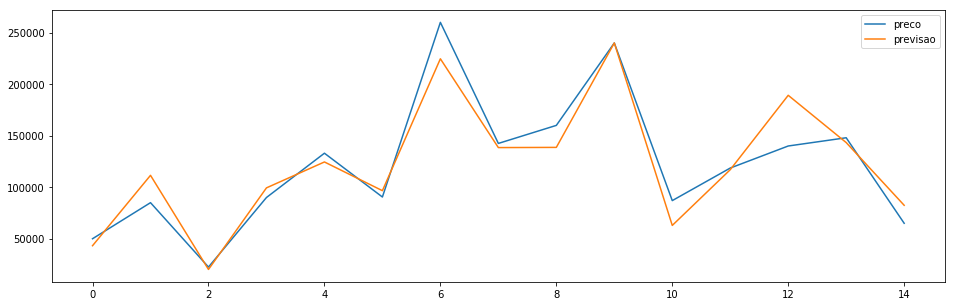

In [31]:
%matplotlib inline
df = historico.DataFrame()

df[['preco', 'previsao']].plot(figsize=(16,5))